download


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\win7/.torch\models\resnet34-333f7ec4.pth
100%|████████████████████████| 87306240/87306240 [00:02<00:00, 35181025.08it/s]


full_model ready
Linear(in_features=512, out_features=5005, bias=True)
Train Begin
Epoch 0 / 20
Training: Elapsed time: 755.3449 Loss: 5.9026 Acc: 0.3795
Epoch 1 / 20
Training: Elapsed time: 1498.7988 Loss: 5.6439 Acc: 0.3802
Epoch 2 / 20
Training: Elapsed time: 2243.6270 Loss: 5.4749 Acc: 0.3803
Epoch 3 / 20
Training: Elapsed time: 3001.4568 Loss: 5.3153 Acc: 0.3821
Epoch 4 / 20
Training: Elapsed time: 3764.0976 Loss: 5.1653 Acc: 0.3845
Epoch 5 / 20
Training: Elapsed time: 4540.0842 Loss: 5.0280 Acc: 0.3861
Epoch 6 / 20
Training: Elapsed time: 5309.6198 Loss: 4.9093 Acc: 0.3895
Epoch 7 / 20
Training: Elapsed time: 6087.2462 Loss: 4.8065 Acc: 0.3904
Epoch 8 / 20
Training: Elapsed time: 6937.0968 Loss: 4.7207 Acc: 0.3906
Epoch 9 / 20
Training: Elapsed time: 7778.9679 Loss: 4.6592 Acc: 0.3908
Epoch 10 / 20
Training: Elapsed time: 8607.2953 Loss: 4.6210 Acc: 0.3913
Epoch 11 / 20
Training: Elapsed time: 9583.8932 Loss: 4.9161 Acc: 0.3861
Epoch 12 / 20
Training: Elapsed time: 10620.2694 Los

<IPython.core.display.Javascript object>


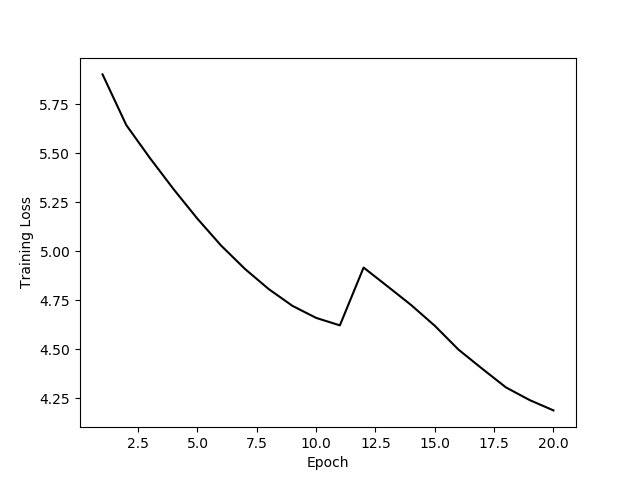

Text(0,0.5,'Training Loss')

In [1]:
% matplotlib notebook
 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas
import PIL
import os.path
import time
import skimage, skimage.io
import copy
from PIL import Image
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook
%run my_utils.ipynb
%run Resnet.ipynb
    
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225] 

df = pandas.read_csv('input/train.csv')
#grouped = df.groupby('Id')
#df['occurrences'] =  grouped.Id.transform('count')
#train_images = glob('input/train/*jpg')
#unique = pandas.value_counts(df.Id)
#num_classes = unique.values.shape[0]
#plt.figure()
#plt.plot(range(1,num_classes),unique.values[1:],'-k')
#plt.xlabel('labels converted to arbitray int')
#plt.ylabel('occurences')
#plt.show()
#df["Image"] = df["Image"].map( lambda x : x)
#ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

#SIZE = 64
#image are imported with a resizing and a black and white conversion
#def ImportImage( filename):
#    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
#    return np.array(img)[:,:,0]
#train_img = np.array([ImportImage( img) for img in train_images])
#x = train_img
#print( "%d training images" %x.shape[0])

#print( "Nbr of samples/class\tNbr of classes")
#for index, val in df["Id"].value_counts().value_counts().sort_index().iteritems():
#    print( "%d\t\t\t%d" %(index,val))
    
transforms_augm = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20.0), 
    torchvision.transforms.RandomGrayscale(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(MEAN, STD) 
    ])
full_data = WhaleDataset(df,'input',transform=transforms_augm)
full_dataloader = {'train': torch.utils.data.DataLoader(full_data,\
                                                   batch_size=4,\
                                                   num_workers=0,\
                                                   shuffle=True,\
                                                   sampler=None)}

print("download")
full_model = torchvision.models.resnet34(pretrained=True)
print("full_model ready")
for params in full_model.parameters():
    params.requires_grad == False
    
num_in = full_model.fc.in_features
num_out = len(full_dataloader['train'].dataset.categories)
full_model.fc = torch.nn.Linear(num_in,num_out)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model.to(device)
print(full_model.fc)

criterion = torch.nn.CrossEntropyLoss()
full_optimizer = torch.optim.SGD(full_model.fc.parameters(),lr=0.001, momentum=0.9)

print("Train Begin")
full_model, loss_vals, acc_vals = train_with_restart(
    full_model,full_dataloader,criterion,full_optimizer,device,\
    use_val=False,num_epochs=20)
torch.save(full_model,'full_model.pt')
plt.figure()
plt.plot(range(1,21),loss_vals['train'],'-k')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

In [2]:
% matplotlib notebook
 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas
import PIL
import os.path
import time
import skimage, skimage.io
import copy
from PIL import Image
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
%run my_utils.ipynb
%run Resnet.ipynb
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
full_model = torch.load('./full_model.pt')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model.to(device);
filenames = os.listdir('./input/test')

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(MEAN, STD) 
    ])

test_df = pandas.DataFrame({'Id':filenames})
test_data = TestDataset(test_df,'input/test',transform=transforms)


train_df = pandas.read_csv('input/train.csv')
train_data = WhaleDataset(train_df,'input/',transform=None)
categories = train_data.categories
test_dataloader = torch.utils.data.DataLoader(test_data,\
                                               batch_size=4,\
                                               num_workers=0,\
                                               shuffle=False,\
                                               sampler=None)

print("Begin")
result = predict(full_model,test_dataloader,device,categories)
result.to_csv('my_submission.csv',index=False)
print("Done")

Begin
Elapsed time: 190.3408
Done
